# IS4303 IT-MEDIATED FINANCIAL SOLUTIONS AND PLATFORMS
## Homework 1 - Data Preprocessing and Linear Model
### Due Date: Feb. 13 (Sat.), 2021, 23:00 SG Time
### Name your .ipynb file as "StudentID_YourName_HW1.ipynb" and then upload

<div class="alert alert-warning">
<b>Python Version:</b> 3.7+<br>Create a virtual environment in Anaconda if needed.
</div>

## Sections
<ul>
    <li><a href="#Section_0" style="text-decoration: none">0. Assignment Overview</a></li>
    <li><a href="#Section_1" style="text-decoration: none">1. ETL</a></li>
    <li><a href="#Section_2" style="text-decoration: none">2. A Simply Implementation</a></li>
</ul>

<a id="Section_0"></a>
## 0 Assignment Overview

* The goal of this assignment is to understand how to do ETL (Extract, Transform, Load) and run simple linear model
* In this assignment, we will clean data and build linear models using a loan dataset. 
* A dataset containing complete loan data for all loans issued has been uploaded on Luminus. It includes the current loan status (Current, Late, Fully Paid, etc.) and a large set of attributes for each customer. 
* The assignment will require you to use the dataset to build models to predict loan default.
* Please answer the questions and write the code / results in the empty cells. 
* 45 pts in total

---

<a id="Section_1"></a>
## 1. ETL (41.5 pts)

In [55]:
#!usr/bin/env python
#-*- coding:utf-8 -*-
from __future__ import division, print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt, log
from collections import defaultdict
from IPython.display import HTML
%matplotlib inline

<a id="Section_1.1"></a>
### 1.1 Load the data (1 pt)
* Read data by pandas and name it as "loans". (0.5 pts)

In [56]:
# Read data by pandas and name it as "loans".
loans = pd.read_csv('/Users/chandya/Desktop/IS4303/HW1/LoanStats_securev1_2020Q1.csv', header=1, low_memory=False)
print(loans)

               id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
0       166907367        NaN       3500         3500             3500   
1       166795268        NaN       5000         5000             5000   
2       168697246        NaN      32800        32800            32800   
3       168186203        NaN      40000        40000            40000   
4       168657451        NaN      10000        10000            10000   
...           ...        ...        ...          ...              ...   
105006  163119880        NaN      10525        10525            10525   
105007  163267959        NaN      16000        16000            16000   
105008  163221893        NaN      10000        10000            10000   
105009  163197179        NaN       7500         7500             7500   
105010  162914373        NaN      20000        20000            20000   

              term int_rate  installment grade sub_grade  ...  \
0        36 months   11.71%       115.77     B        B3  

* Show how many rows and columns such dataset has (0.5 pts)

In [57]:
# show how many rows and columns such dataset has
# row count
count_row = loans.shape[0] 
# column count
count_col = loans.shape[1]  
print("There are {} rows and {} columns.".format(count_row, count_col))


There are 105011 rows and 150 columns.


<a id="Section_1.2"></a>
### 1.2 Target variable (4.5 pts)
The event of interest is whether a loan-application candidate is a defaulter or not. The variable "*loan_status*" can fundamentally satisfy our requirement. We firstly take a close look at it.
#### 1.2.1 List all the unique values of "*loan_status*" and count how many are they in the data set (1 pt)

In [58]:
# list all the unique values of loan status and count the volume of them
df = pd.DataFrame(loans)
print("The unique values of loan_status variable is {}. \n" .format(loans['loan_status'].unique()))
print("The number of data for each of these values are \n {}.".format(loans['loan_status'].value_counts()))

The unique values of loan_status variable is ['Current' 'Fully Paid' 'Late (31-120 days)' 'Charged Off'
 'In Grace Period' 'Late (16-30 days)' 'Default']. 

The number of data for each of these values are 
 Current               90419
Fully Paid            11018
Charged Off            1203
Late (31-120 days)     1193
In Grace Period         871
Late (16-30 days)       304
Default                   3
Name: loan_status, dtype: int64.


#### 1.2.2 Process the original target variable (1 pts)  
Since we cannot identify the final outcomes of those loans in the future when their status is '**current**' or '**n**' or other unidentifiable values such as null value to date, these data will not be considered to train our supervised model. Thus, we remove them from our dataset. 
<div class="alert alert-warning">
<b>Note: </b>In practice, the data we removed in this step is something like ongoing or upcoming new instances that have not been labeled and need to be predicted on the event/variable of interest by our (supervised) machine learning model.
</div>

In [59]:
# reset "loans" dataset by removing the rows whose "loan_status" is 'current' or 'n'
df1 = loans[loans['loan_status'] != 'Current']
loans = df1[df1['loan_status'] != 'n']
for status in loans['loan_status']:
    if status == 'Current' or status == 'n':
        print("There are still some current and n data values.")

print ("There are no data with current or n values.")

There are no data with current or n values.


#### 1.2.3 Create a new target/outcome/dependent variable for predictive task (1 pt)   
New target variable, entitled "*bad_loans*" takes 1 if a loan is a **bad loan** (i.e., its *loan_status* is labeled by one of '**Late (31-120 days)**', '**Late (16-30 days)**', '**Charged Off**', and '**Default**') and 0 otherwise (i.e., its *loan_status* is labeled by either '**Fully Paid**' or '**In Grace Period**').

In [60]:
# Create the new target variable, bad_loans: 1 if the loan is risky and 0 otherwise.
conditions = [
    (loans['loan_status'] == 'Fully Paid'),
    (loans['loan_status'] == 'In Grace Period'),
    (loans['loan_status'] == 'Late (31-120 days)'),
    (loans['loan_status'] == 'Late (16-30 days)'),
    (loans['loan_status'] == 'Charged Off'),
    (loans['loan_status'] == 'Default'),
    ]

values = [0, 0, 1, 1, 1, 1]

# create a new column and use np.select to assign values to it using our lists as arguments
loans['bad_loans'] = np.select(conditions, values)

print(loans['bad_loans'])

7         0
12        0
15        0
28        0
32        0
         ..
104995    0
105000    0
105003    0
105006    0
105007    0
Name: bad_loans, Length: 14592, dtype: int64


#### 1.2.4 Show the number of **bad loans** and **good loans** in the dataset. Then draw a pie chart or histogram over "bad_loans", and display the distribution for each of the two sections. (1.5 pts)
<div class="alert alert-warning">
<b>Note: </b>For loan or credit card application data, it is very possible that the data is unbalanced. We can plot a pie chart or histogram to clarify and detect such a problem.
</div>

Good Loans: 11889
Bad loans : 2703


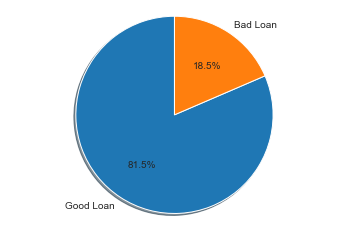

In [61]:
# How many bad loans and good loans are in the dataset now?
df_good = loans[loans['bad_loans'] == 0]
print('Good Loans:', len(df_good))
df_bad = loans[loans['bad_loans'] == 1]
print('Bad loans :', len(df_bad))

# Draw the histogram

labels = 'Good Loan', 'Bad Loan'
sizes = [len(df_good), len(df_bad)]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

<a id="Section_1.3"></a>
### 1.3 Feature Selection (1) (1 pt)
Although as aforementioned we have 150 features, we select 32 out of them based on our knowledge and put those 32 features into our feature pool, we may make further refinement as exercise of feature selection later.  
* Try deepcopy() to generate a copy of the data '*loans*'. Name this new dataset '**loans_new**'. Note the difference between shallow copy and deep copy in Python. (0.5 pt)  
* Then, process the copy version of the dataset such that it only includes the selected features plus the target variable 'bad_loans'. (0.5 pt)


In [62]:
from copy import deepcopy

loans_new = deepcopy(loans)
# shallow copy : changes to loans_new may affect children in loans
# deep copy : fully independent cloning hence modification will not change original copy

feature_pool = ['acc_now_delinq','acc_open_past_24mths','annual_inc','application_type','avg_cur_bal',\
                'chargeoff_within_12_mths','collections_12_mths_ex_med','delinq_2yrs','delinq_amnt','dti',\
                'emp_length','fico_range_high','fico_range_low','home_ownership','il_util','inq_fi',\
                'installment','int_rate','last_pymnt_amnt','loan_amnt','mths_since_last_delinq','num_bc_tl','num_il_tl',\
                'num_tl_120dpd_2m','num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m','open_acc_6m',\
                'open_act_il','open_il_24m','pct_tl_nvr_dlq','percent_bc_gt_75','revol_util','tot_cur_bal']
output = 'bad_loans'
loans_new = loans_new[['acc_now_delinq','acc_open_past_24mths','annual_inc','application_type','avg_cur_bal',\
                'chargeoff_within_12_mths','collections_12_mths_ex_med','delinq_2yrs','delinq_amnt','dti',\
                'emp_length','fico_range_high','fico_range_low','home_ownership','il_util','inq_fi',\
                'installment','int_rate','last_pymnt_amnt','loan_amnt','mths_since_last_delinq','num_bc_tl','num_il_tl',\
                'num_tl_120dpd_2m','num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m','open_acc_6m',\
                'open_act_il','open_il_24m','pct_tl_nvr_dlq','percent_bc_gt_75','revol_util','tot_cur_bal', 'bad_loans']]
print(loans_new)

        acc_now_delinq  acc_open_past_24mths  annual_inc application_type  \
7                    0                     6     90000.0       Individual   
12                   0                     4     73000.0       Individual   
15                   0                     0     15156.0        Joint App   
28                   0                     3     65000.0       Individual   
32                   0                     2     61000.0       Individual   
...                ...                   ...         ...              ...   
104995               0                     2    120000.0       Individual   
105000               0                    24    115000.0       Individual   
105003               0                     4     38500.0       Individual   
105006               0                     8     40000.0       Individual   
105007               0                    15     80000.0       Individual   

        avg_cur_bal  chargeoff_within_12_mths  collections_12_mths_ex_med  

<a id="Section_1.4"></a>
### 1.4 Data Transform (8.5 pts)
#### 1.4.1 Identify which columns are not numerical type (0.5 pt)

In [63]:
# Type of features
# Check if there are any non-numerical types left
numerics = ['uint8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']

new_data = loans_new.select_dtypes(exclude=numerics)

for col in new_data.columns: 
    print(col)
    print(type(col))

application_type
<class 'str'>
emp_length
<class 'str'>
home_ownership
<class 'str'>
int_rate
<class 'str'>
revol_util
<class 'str'>


#### 1.4.2 Transformation (5 pts)
* Categorical variable (2.5 pts)
 * "*application_type*" takes 1 if it is originally assigned '*Individual*' and 0 otherwise (0.5 pt)
 * '*home_ownership*' take value from four values: '**MORTGAGE**', '**OWN**', '**RENT**', and '**ANY**'. Create dummies for '*home_ownership*': You may refer to <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html" target="_blank" class="btn btn-success" role="button" style="text-decoration: none">get_dummies()</a> about how to do this. We require you to drop column "*home_ownership*", and one of the four dummies to avoid **multicollinearity** after dummy-generation.Integrate the three dummies to dataset (2 pts)
 
* Numerical variable (2.5 pts)
 * '*emp_length*': Remove its textual part and transform the remaining to '**float**' type. No need to divide it by 100 further. Note that there may be null values in this column. You can keep them as **float('nan')** for the time being. We will deal with the missing value issue later. (1 pt)
 * '*int_rate*' and '*revol_util*': Remove the '%' from them and transform the digital string's type to '**float**' type. Note that there may be null values in either one of or both of them as '*emp_length*'. You can keep them as **float('nan')** for the time being. (1.5 pts)
 

<div class="alert alert-warning">
<b>Note: </b>
    <p>
    You may need to drop the index of dataframe by dataframe_variable.reset_index(drop=True, inplace=True) if there is any unexpected Nan values generated. Refer to <a href="https://stackoverflow.com/questions/40339886/pandas-concat-generates-nan-values">https://stackoverflow.com/questions/40339886/pandas-concat-generates-nan-values</a> for similar issue you met
</div>

In [64]:
# Transform object type of "application_type" to numerical type
conditions = [
    (loans_new['application_type'] == 'Individual'),
    (loans_new['application_type'] != 'Individual')
    ]

values = [1, 0]

loans_new['application_type'] = np.select(conditions, values)

# Transform object(string) and non-categorial type of "home_ownership" to numerical type:
dummies = pd.get_dummies(loans_new['home_ownership'], prefix='home_ownership', drop_first = True)
loans_new  = loans_new.drop(columns=['home_ownership'])
loans_new = pd.concat([loans_new, dummies], axis=1)


# Transform object type of emp_length to numerical type: 
for i, v in loans_new['emp_length'].items():
    if not isinstance(v, float):
        new_v = ''.join(c for c in v if c.isdigit())
        loans_new.at[i, 'emp_length'] = new_v
        
loans_new['emp_length'] = pd.to_numeric(loans_new['emp_length'])
    
# Transform object type of int_rate to numerical type
for i, v in loans_new['int_rate'].items():
    if not isinstance(v, float):
        new_v = v.replace('%', '')
        loans_new.at[i, 'int_rate'] = new_v
        
loans_new['int_rate'] = pd.to_numeric(loans_new['int_rate'], errors='coerce')

for i, v in loans_new['revol_util'].items():
    if not isinstance(v, float):
        new_v = v.replace('%', '')
        loans_new.at[i, 'revol_util'] = new_v
        
loans_new['revol_util'] = pd.to_numeric(loans_new['revol_util'], errors='coerce')

# Check if all columns have numeric data types
numerics = ['uint8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
new_data = loans_new.select_dtypes(exclude=numerics)
for col in new_data.columns: 
    if (type(col) not in numerics):
        print ("There are columns with non-numeric data types.")
print ("All columns have numeric data types.")

All columns have numeric data types.


#### 1.4.3 Short Answer Question (3.0 pts)

Categorical variables are also known as discrete or qualitative variables. It can be further categorized as either nominal or ordinal variable.

An ordinal variable is such that its possible values can be ordered. It can be considered “in between” categorical and quantitative variables. Common examples could be education level, grade, willingness, etc. Thus, it is very possible that they take non-numeric and categorical value. Thus, we need to transform them to numeric type data if we want to use them in our machine learning model.

If you read the metadata file, *LCDataDictionary.xlsx*, you will find one variable called '*grade*' (a more precise one is called '*subgrade*') which is an indicator to suggest the risk level of one finance loan. Specifically, one loan will be riskier if its grade is alphabetically rearward positioned from A to G (as a result, the corresponding interest rate will be higher). Therefore, it is an ordinal variable. 

Please read relevant information at https://www.lendingclub.com/foliofn/rateDetail.action and find the exact mapping relation among grade, subgrade and interest rate (see **table 1** and **2** in the link). Is "MODEL RANK" shown in **table 1** a good **transformed** numeric *subgrade* ? Provide your justification. Write your answer in the cell below.

In [65]:
# Grade reflects on risk level and risk level will correlate to interest rate.
# Although final interest rate is calculated by adding lending club base rate to some percentage adjustment
# for risk  and volatility, lending club base rate is a constant 5.05%. Therefore it is the adjustments that affects
# grade non-linearly. This can be known because the differences between the different adjustment percentages are much different
# and inconsistent. Hence for example the difference between grade A and B which is difference between subgrade A5 and B1 is not the same as 
# difference between grade B and C aka subgrade B5 and C1. Hence, mapping model rank column linearly to risk level 
# will not give an accurate picture of the final interest rate.

<a id="Section_1.5"></a>
### 1.5 Data Splitting (0.5 pts)
* Split dataset into train and test set at the rate of train set: test set using = 70/30.
* Try sklearn.model_selection.train_test_split() and set *random_state*=42 for this function to make sure the result is replicatable

In [66]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(loans_new, 
                         train_size=0.70,
                         test_size=0.30, random_state=42)    # Split the data set by a 70/30 ratio

print(train.shape)                          # Print the shape of the training set
print(test.shape)                           # Print the shape of the test set

(10214, 37)
(4378, 37)
39083     0
69474     0
8063      0
101865    0
88627     1
         ..
45219     0
39031     0
51763     0
93583     1
24654     0
Name: bad_loans, Length: 4378, dtype: int64


<a id="Section_1.6"></a>
### 1.6 Missing Values (7 pts)
#### 1.6.1 Check missing values (1 pt)
* Count how many missing values there are in every column of *loans_new*. (0.5 pt)
* Check whether those columns with missing values in the train set are exactly the same as those with missing values in the whole set *loans_new*. (0.5 pt)

In [67]:
# Count missing value
col_sum = loans_new.isnull().sum(axis = 0)
print(col_sum)
print("\n")
# check the consistency of columns with missing value between train set and the whole set
train_col_sum = train.isnull().sum(axis=0)

# columns to check are ['avg_cur_bal', 'dti', 'emp_length', 'il_util', 'mths_since_last_delinq','num_tl_120dpd_2m', 'percent_bc_gt_75', 'revol_util']

train_check = set(train[['avg_cur_bal', 'dti', 'emp_length', 'il_util', 'mths_since_last_delinq','num_tl_120dpd_2m', 'percent_bc_gt_75', 'revol_util']])
loans_check = set(loans_new[['avg_cur_bal', 'dti', 'emp_length', 'il_util', 'mths_since_last_delinq','num_tl_120dpd_2m', 'percent_bc_gt_75', 'revol_util']])

if (train_check.issubset(loans_check)):
    print("Columns with missing values in the train set are exactly the same as those with missing values in the \nwhole set loans_new.")
else:
    print("Columns with missing values in the train set are not the same as those with missing values in the \nwhole set loans_new.")


acc_now_delinq                   0
acc_open_past_24mths             0
annual_inc                       0
application_type                 0
avg_cur_bal                      3
chargeoff_within_12_mths         0
collections_12_mths_ex_med       0
delinq_2yrs                      0
delinq_amnt                      0
dti                             37
emp_length                    1175
fico_range_high                  0
fico_range_low                   0
il_util                       1852
inq_fi                           0
installment                      0
int_rate                         0
last_pymnt_amnt                  0
loan_amnt                        0
mths_since_last_delinq        8323
num_bc_tl                        0
num_il_tl                        0
num_tl_120dpd_2m               102
num_tl_30dpd                     0
num_tl_90g_dpd_24m               0
num_tl_op_past_12m               0
open_acc_6m                      0
open_act_il                      0
open_il_24m         

#### 1.6.2 Check missing values Missing value processing (6 pts)
* We can see variable "*mths_since_last_delinq*" has over 3/5 missing values over the whole dataset. Thus, one common way is to directly drop this column from the train and test sets. Remember to update *feature_pool*. (1 pt)  
* For the remaining columns containing missing values, we try steps as follows. You may consider **dataframe_variable.fillna()** for some of those steps. (5 pts) 
 * For '*num_tl_120dpd_2m*', use its **modes** in the **train set** to fill the missing values of '*num_tl_120dpd_2m*' of both train and test sets (0.5 pt)    
 * For '*avg_cur_bal*', use the **last non-null value in the same column** to fill the current missing value. Apply fillna() function on both train and test sets (0.5 pt) 
 * For '*dti*', use its **median** in the **train set** to fill the missing values of '*dti*' of both train and test set (0.5 pt) 
 * For columns ('il_util','percent_bc_gt_75'), use their **mean**s in the **train set** to fill their missing values of '*il_util*' and '*percent_bc_gt_75*' of both train and test sets (1.0 pt) 
 * For the remaining features, fill them by **KNN** algorithm. You may want to consider **Fancyimpute** which is a third-party toolkit for Python that provides implementations of various matrix calculations and fill algorithms.Use KNN() method to fill missing values and set **k=6** for the KNN model. For more information about how to install and use it, see https://pypi.org/project/fancyimpute/#modal-close and https://www.programmersought.com/article/6816273881/. Alternatively, if you have problem with installing fancyimpute, you can try similar function of package **sklearn.impute**. For more information, see section 6.4.5 at https://scikit-learn.org/stable/modules/impute.html#impute. **Note: Although KNN-filling is essentially machine learning process to predict those missing values, we cannot fill the missing values in the test set by a trained model on train set since the two toolkits do not provide fit() function to train a model. As a consequence, please just apply KNN().fit_transform() on both train and test set respectively as what we required for '*avg_cur_bal*'** (2.0 pts) 
 
 * Check again whether there are any missing values in train and test sets (0.5 pt) 
 
<div class="alert alert-warning">
<b>Note: </b>
    <P>
    1. When you use fillna(), be careful with <B>replace</B> parameter because you need to modify the original variable but not a review. You may refer to <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html" target="_blank" class="btn btn-success" role="button" style="text-decoration: none">DataFrame.fillna()</a><br>
    2. In practice, if the missing values are very less out of the whole volume, we can directly drop those rows with missing values.<br>    
</div>

In [68]:
from sklearn.impute import KNNImputer

# drop "mths_since_last_delinq" from the dataset

feature_pool = ['acc_now_delinq','acc_open_past_24mths','annual_inc','application_type','avg_cur_bal',\
                'chargeoff_within_12_mths','collections_12_mths_ex_med','delinq_2yrs','delinq_amnt','dti',\
                'emp_length','fico_range_high','fico_range_low','il_util','inq_fi',\
                'installment','int_rate','last_pymnt_amnt','loan_amnt', 'num_bc_tl','num_il_tl',\
                'num_tl_120dpd_2m','num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m','open_acc_6m',\
                'open_act_il','open_il_24m','pct_tl_nvr_dlq','percent_bc_gt_75','revol_util','tot_cur_bal', 'home_ownership_MORTGAGE',  'home_ownership_OWN' , 'home_ownership_RENT']

loans_new  = loans_new.drop(columns=['mths_since_last_delinq'])
train  = train.drop(columns=['mths_since_last_delinq'])
test  = test.drop(columns=['mths_since_last_delinq'])

print("mths_since_last_delinq columns is dropped from {}\n".format(train.columns))

# process missing values in the 'num_tl_120dpd_2m'
mode = train['num_tl_120dpd_2m'].mode()
train['num_tl_120dpd_2m'] = train['num_tl_120dpd_2m'].fillna(mode[0])
test['num_tl_120dpd_2m'] = test['num_tl_120dpd_2m'].fillna(mode[0])

# process missing values in the 'avg_cur_bal'
train['avg_cur_bal'] = train['avg_cur_bal'].fillna(method='ffill')
test['avg_cur_bal'] = test['avg_cur_bal'].fillna(method='ffill')
# process missing values in 'dti'

median = train['dti'].median()
train['dti'] = train['dti'].fillna(median)
test['dti'] = test['dti'].fillna(median)

# process missing values in ('il_util','percent_bc_gt_75')
mean_1 = train['il_util'].mean()
mean_2 = train['percent_bc_gt_75'].mean()
train['il_util'] = train['il_util'].fillna(mean_1)
test['il_util'] = test['il_util'].fillna(mean_1)
train['percent_bc_gt_75'] = train['percent_bc_gt_75'].fillna(mean_2)
test['percent_bc_gt_75'] = test['percent_bc_gt_75'].fillna(mean_2)

# filling the remaining with KNN data
imputer = KNNImputer(n_neighbors=6)
train = imputer.fit_transform(train)
test = imputer.fit_transform(test)


# check again whether there are any missing values
array_sum = np.sum(train)
train_has_nan = np.isnan(array_sum)

array_sum = np.sum(test)
test_has_nan = np.isnan(array_sum)
train = pd.DataFrame(train)
test = pd.DataFrame(test)

train.columns =  ['acc_now_delinq','acc_open_past_24mths','annual_inc','application_type','avg_cur_bal',\
                'chargeoff_within_12_mths','collections_12_mths_ex_med','delinq_2yrs','delinq_amnt','dti',\
                'emp_length','fico_range_high','fico_range_low','il_util','inq_fi',\
                'installment','int_rate','last_pymnt_amnt','loan_amnt', 'num_bc_tl','num_il_tl',\
                'num_tl_120dpd_2m','num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m','open_acc_6m',\
                'open_act_il','open_il_24m','pct_tl_nvr_dlq','percent_bc_gt_75','revol_util','tot_cur_bal', 'bad_loans',  'home_ownership_MORTGAGE',  'home_ownership_OWN' , 'home_ownership_RENT']
test.columns =  ['acc_now_delinq','acc_open_past_24mths','annual_inc','application_type','avg_cur_bal',\
                'chargeoff_within_12_mths','collections_12_mths_ex_med','delinq_2yrs','delinq_amnt','dti',\
                'emp_length','fico_range_high','fico_range_low','il_util','inq_fi',\
                'installment','int_rate','last_pymnt_amnt','loan_amnt', 'num_bc_tl','num_il_tl',\
                'num_tl_120dpd_2m','num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m','open_acc_6m',\
                'open_act_il','open_il_24m','pct_tl_nvr_dlq','percent_bc_gt_75','revol_util','tot_cur_bal', 'bad_loans',  'home_ownership_MORTGAGE',  'home_ownership_OWN' , 'home_ownership_RENT']

if not train_has_nan:
    print("Train data has no missing values.")
if not test_has_nan:
    print("Test data has no missing values.")
    



mths_since_last_delinq columns is dropped from Index(['acc_now_delinq', 'acc_open_past_24mths', 'annual_inc',
       'application_type', 'avg_cur_bal', 'chargeoff_within_12_mths',
       'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'dti',
       'emp_length', 'fico_range_high', 'fico_range_low', 'il_util', 'inq_fi',
       'installment', 'int_rate', 'last_pymnt_amnt', 'loan_amnt', 'num_bc_tl',
       'num_il_tl', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m',
       'num_tl_op_past_12m', 'open_acc_6m', 'open_act_il', 'open_il_24m',
       'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'revol_util', 'tot_cur_bal',
       'bad_loans', 'home_ownership_MORTGAGE', 'home_ownership_OWN',
       'home_ownership_RENT'],
      dtype='object')

Train data has no missing values.
Test data has no missing values.


<a id="Section_1.7"></a>
### 1.7 Outlier Detection (1.5 pts)
* Plot boxplot to detect outliers for columns '*dti*','*int_rate*','*loan_amnt*' (1 pt)

<div class="alert alert-warning">
<b>Note: <p>You can refer to: </p>
<div class="btn-group">    
    <a href="http://www.physics.csbsju.edu/stats/box2.html" target="_blank" class="btn btn-primary" role="button" style="text-decoration: none">Boxplot</a>
    <a href="https://matplotlib.org/api/_as_gen/matplotlib.pyplot.boxplot.html" target="_blank" class="btn btn-success" role="button" style="text-decoration: none">Matplotlib</a>
    <a href="https://seaborn.pydata.org/generated/seaborn.boxplot.html" target="_blank" class="btn btn-info" role="button" style="text-decoration: none">Seaborn</a>
</div>

AxesSubplot(0.125,0.125;0.775x0.755)


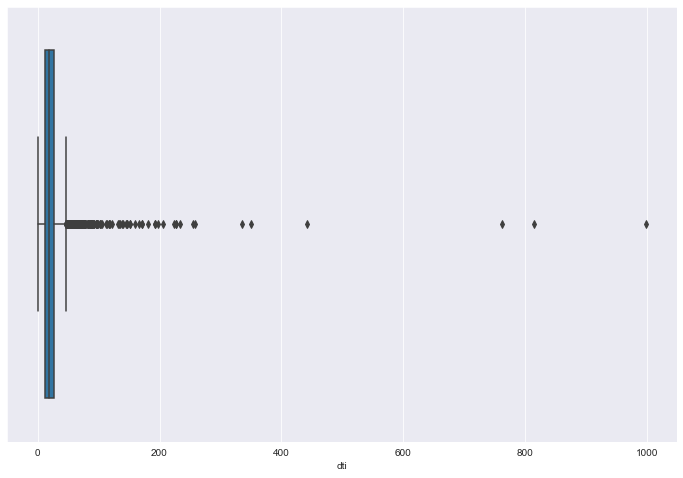

In [69]:
# Plot Boxplot
import seaborn as sns
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12,8)
plot = sns.boxplot(x=train["dti"])

print(plot)

AxesSubplot(0.125,0.125;0.775x0.755)


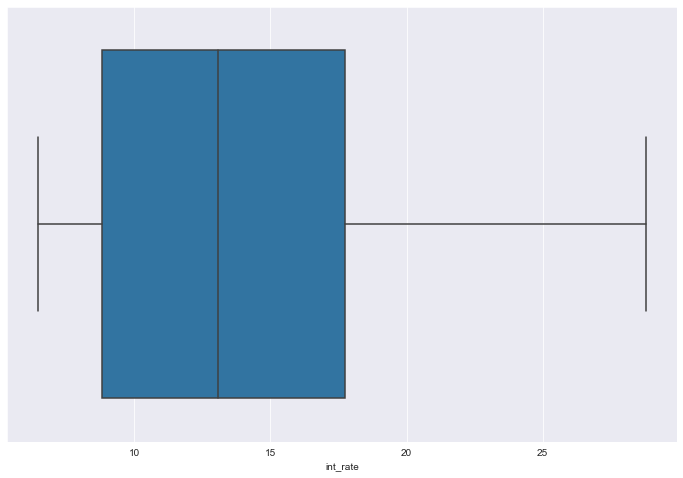

In [70]:
# Plot boxplot for column 'int_rate'
plot = sns.boxplot(x=train["int_rate"])

print(plot)

AxesSubplot(0.125,0.125;0.775x0.755)


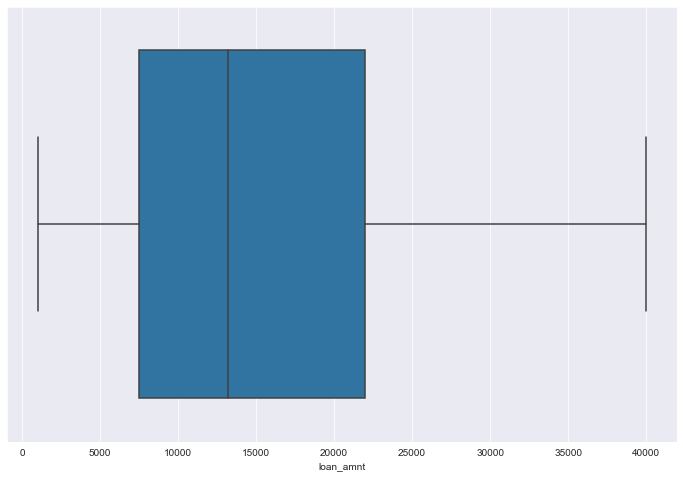

In [71]:
# Plot boxplot for column 'loan_amnt'

plot = sns.boxplot(x=train["loan_amnt"])

print(plot)

* Whether are there outliers in the three columns? (0.5 pt)

In [72]:
# No outliers for int_rate and loan_amount
# High amount of outlier for dti 

<a id="Section_1.11"></a>
### 1.8 Feature Rescaling (6.5 pts)
#### 1.8.1 Standardization (3.5 pts)
In this section, we will standardize some features. You may use <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html">sklearn.preprocessing.StandardScaler()</a> 
* Fit a scaler on **train** subset that needs to be rescaled. (1 pts)
 * You need to do standardization on all the features defined by *standardized_features* below.
* Use the **fitted scaler** above to standardize **train** and **test** sets respectively (1 pts)
* Recover column names of both standardized train and test sets to original column names (1 pts)
* Re-integrate the standardized and non-standardized data together for both train and test sets (0.5 pts)

<div class="alert alert-warning">
<b>Note: </b>
    <p>
    1. preprocessing.StandardScaler().transform() return 'numpy.ndarray' but not 'DataFrame' 
    <p>
    3. The tricky part is that Nan values may be generated when you integrate the standardized and non-standardized data together. To deal with this potential problem, you need to drop the index of dataframe by dataframe_variable.reset_index(drop=True, inplace=True)
</div>

In [73]:
from sklearn import preprocessing
# standardized features:
standardized_features = ['annual_inc','avg_cur_bal','delinq_amnt','dti','fico_range_high','fico_range_low','il_util',\
                'installment','int_rate','loan_amnt','num_bc_tl','num_il_tl',\
                'open_il_24m','tot_cur_bal']   

train_subset = train[['annual_inc','avg_cur_bal','delinq_amnt','dti','fico_range_high','fico_range_low','il_util',\
                'installment','int_rate','loan_amnt','num_bc_tl','num_il_tl',\
                'open_il_24m','tot_cur_bal']]
test_subset = test[['annual_inc','avg_cur_bal','delinq_amnt','dti','fico_range_high','fico_range_low','il_util',\
                'installment','int_rate','loan_amnt','num_bc_tl','num_il_tl',\
                'open_il_24m','tot_cur_bal']]

scaler = preprocessing.StandardScaler()
# fit a scaler on train subset that needs to be rescaled
scaler.fit(train_subset) 
train_subset = scaler.transform(train_subset)
train_subset = pd.DataFrame(train_subset)

# recover names
train_subset.columns =  ['annual_inc','avg_cur_bal','delinq_amnt','dti','fico_range_high','fico_range_low','il_util',\
                'installment','int_rate','loan_amnt','num_bc_tl','num_il_tl',\
                'open_il_24m','tot_cur_bal']

test_subset = scaler.transform(test_subset)
test_subset = pd.DataFrame(test_subset)

# recover names
test_subset.columns =  ['annual_inc','avg_cur_bal','delinq_amnt','dti','fico_range_high','fico_range_low','il_util',\
                'installment','int_rate','loan_amnt','num_bc_tl','num_il_tl',\
                'open_il_24m','tot_cur_bal']
# merge non-standardized features and standardized features
non_standardized_features = list(set(feature_pool)-set(standardized_features))

output_bad_loans_train = train["bad_loans"]
train_nonstandard = train[non_standardized_features]
train = train_nonstandard.join(train_subset)

output_bad_loans_test = test["bad_loans"]

test_nonstandard = test[non_standardized_features]
test = test_nonstandard.join(test_subset)

# check again whether there are any missing values

train_has_nan = train.isnull().values.any()

test_has_nan = test.isnull().values.any()

if not train_has_nan:
    print("Train data has no missing values.")
if not test_has_nan:
    print("Test data has no missing values.\n")

print("Reintegrated training data \n{} :\n".format(train))
print("Reintegrated test data \n{} :".format(test))

Train data has no missing values.
Test data has no missing values.

Reintegrated training data 
       num_tl_op_past_12m  inq_fi  home_ownership_OWN  \
0                     1.0     1.0                 0.0   
1                     2.0     1.0                 0.0   
2                     6.0     1.0                 0.0   
3                     4.0     1.0                 0.0   
4                     0.0     0.0                 0.0   
...                   ...     ...                 ...   
10209                 2.0     2.0                 0.0   
10210                 2.0     2.0                 0.0   
10211                 1.0     1.0                 0.0   
10212                 3.0     0.0                 1.0   
10213                 2.0     2.0                 0.0   

       chargeoff_within_12_mths  percent_bc_gt_75  application_type  \
0                           0.0              66.7               1.0   
1                           0.0              33.3               1.0   
2     

#### 1.8.2 Short Answer Question (3 pts)
Simply explain why we use the train-set-fitted scaler to standardize the test set (3 pts)

In [74]:
# The ML model in this assignment is based on training data set. Therefore it is
# important that test data set is scaled and standardized using the mean and stand deviation of 
# training data set to ensure test data will run on the right model.
# In this cse we are "pretending" that test data is a "new, unseen data" which we use to get a good estimate
# of how well our model performs on new data. In real-life the unseen data we want to use with the model to get 
# an estimate of whether it is a good_loan or bad_loan could just be one point therefore it can't have
# a mean and standard deviation. Therefore we use training data's mean and standard deviation to transform test data.
# This would give the most accurate result when the test data is put through the model that has been trained with training data.

# Example:
# Training data: 
# grade 20 --> bad loan
# grade 30 --> bad loan
# grade 10 --> good loan
# std deviation is 8.2 and mean is 20
# After standardization;
# grade 0 --> bad loan
# grade 1.21 --> bad loan
# grade -1.21 -> good loan
# We can presume our model classifies anything below 0 as good loan and above 0 as bad loan.
# Now our test data is grade 5, grade 6 and grade 7.
# If standardizes with their own mean and std deviation they would be -1.21, 0 and 1.21 which 
# won't make sense because logically they should all be good loans. However when we use training data 
# parameters, they will all be standardized to a negative value hence making them good loans.


<a id="Section_1.8"></a>
### 1.9 Feature Selection (2) (11 pts)
Although as aforementioned we have selected 32 features out of 150 based on our knowledge and put those 32 features into our feature pool, we can do some more technical feature selection procedures in this section.
#### 1.9.1 Filter method (5 pts)
* Filter and select those features on the train set whose variance is higher than the **threshold (0.16)** we set. You may consider <a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html" target="_blank" class="btn btn-success" role="button" style="text-decoration: none">VarianceThreshold()</a> to do this. (1 pt)  
* Figure out which features are selected by this model and print out them by their names  (0.5 pt)
* Name the new train and test sets as *X_train1* and *X_test1*  (0.5 pt)

<div class="alert alert-warning">
<b>Note: </b>
    <p>
    get_support() may be useful when you want to know which features have been selected.
</div>

In [75]:
from sklearn.feature_selection import VarianceThreshold
# output y here is bad_loans; train and test are dataframes
# find variance for each column (other than bad_loans) and filter > threshold (0.16)
selector = VarianceThreshold(0.16)
selector.fit(train)
selector.fit(test)

# print column names after filter and rename sets 
print(train[train.columns[selector.get_support(indices=True)]].columns)
X_train1 = train[train.columns[selector.get_support(indices=True)]]
X_test1 = test[test.columns[selector.get_support(indices=True)]]

Index(['num_tl_op_past_12m', 'inq_fi', 'percent_bc_gt_75', 'emp_length',
       'open_acc_6m', 'home_ownership_MORTGAGE', 'acc_open_past_24mths',
       'last_pymnt_amnt', 'delinq_2yrs', 'revol_util', 'home_ownership_RENT',
       'pct_tl_nvr_dlq', 'num_tl_90g_dpd_24m', 'open_act_il', 'annual_inc',
       'avg_cur_bal', 'dti', 'fico_range_high', 'fico_range_low', 'il_util',
       'installment', 'int_rate', 'loan_amnt', 'num_bc_tl', 'num_il_tl',
       'open_il_24m', 'tot_cur_bal'],
      dtype='object')


* Filter and select those features on the train set who are more correlated with outcome variable *bad loans*. You may consider <a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html" target="_blank" class="btn btn-success" role="button" style="text-decoration: none">SelectKBest()</a> and <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html" target="_blank" class="btn btn-success" role="button" style="text-decoration: none">scipy.stats.pearsonr(x, y)</a> to do this. Select top *15* of the most correlated features with outcome variable (2 pts)
* Figure out which features are selected by this model and print out them by their names (0.5 pt)
* Name the new train and test sets as *X_train2* and *X_test2* (0.5 pts)

<div class="alert alert-warning">
<b>Note: </b>
    <p>
    get_support() may be useful when you want to know which features have been selected.
</div>

In [76]:
from sklearn.feature_selection import SelectKBest
from scipy.stats import pearsonr
# train (input)
# output_bad_loans_train (target output)
def train_pearsonr(X, y):
    scores, pvalues = [], []
    for tup in map(lambda x: pearsonr(x, y), np.transpose(X)):
        scores.append(abs(tup[0]))
        pvalues.append(tup[1])
        
    return (np.array(scores), np.array(pvalues))

transformer = SelectKBest( score_func = train_pearsonr, k=15)
transformer.fit_transform(train, output_bad_loans_train)
transformer.fit_transform(test, output_bad_loans_test)
print(train[train.columns[transformer.get_support(indices=True)]].columns)

X_train2 = train[train.columns[transformer.get_support(indices=True)]]
X_test2 = test[test.columns[transformer.get_support(indices=True)]]


Index(['percent_bc_gt_75', 'emp_length', 'home_ownership_MORTGAGE',
       'last_pymnt_amnt', 'revol_util', 'home_ownership_RENT', 'avg_cur_bal',
       'dti', 'fico_range_high', 'fico_range_low', 'installment', 'int_rate',
       'loan_amnt', 'num_il_tl', 'tot_cur_bal'],
      dtype='object')


/Users/chandya/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/chandya/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


#### 1.9.2 Wrapper method (2 pts)
* Select those features on the train set in a recursive way with estimator, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html" target="_blank" class="btn btn-success" role="button" style="text-decoration: none">LogisticRegression()</a>. You may consider <a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html" target="_blank" class="btn btn-success" role="button" style="text-decoration: none">RFE()</a> to do the selection. The goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. Select top 15 of the most correlated features with outcome variable. Set **max_iter=10000** for *LogisticRegression(max_iter=10000)* (1 pt)
* Figure out which features are selected by this model and print out them by their names (0.5 pt)
* Name the new train and test set as *X_train3* and *X_test3* (0.5 pt)

<div class="alert alert-warning">
<b>Note: </b>
    <p>
    get_support() may be useful when you want to know which features have been selected.
</div>

In [77]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

reg_selector = RFE(estimator = LogisticRegression(max_iter=10000), n_features_to_select = 15)
reg_selector.fit(train, output_bad_loans_train)

print(train[train.columns[reg_selector.get_support(indices=True)]].columns)

reg_selector.fit(test, output_bad_loans_test)

X_train3 = train[train.columns[reg_selector.get_support(indices=True)]]
X_test3 = test[test.columns[reg_selector.get_support(indices=True)]]

Index(['home_ownership_OWN', 'chargeoff_within_12_mths',
       'home_ownership_MORTGAGE', 'collections_12_mths_ex_med', 'delinq_2yrs',
       'home_ownership_RENT', 'num_tl_90g_dpd_24m', 'annual_inc',
       'delinq_amnt', 'fico_range_high', 'fico_range_low', 'int_rate',
       'loan_amnt', 'num_il_tl', 'tot_cur_bal'],
      dtype='object')


#### 1.9.3 open questions (4 pts)
* Base on your understanding of feature ranking with recursive feature elimination, attempt to "brain store" some ideas about the possible disadvantages of the wrapper method. 

In [78]:
# Recursive feature elimination follows a greedy search approach where it
# aggressively evaluates all possible combinations of features against the evaluation criterion,
# which in this case is the correlation with bad_loans and selects the combination of features
# that gives the optimal result for the specified machine learning algorithm.

# Disadvantages:
# 1. Recursive function is generally slower than non-recursive function, requires alot of memory space to hold
# intermediate results on the system stacks and is inefficient in terms of space and time complexity.
# For example estimated time complexity of forward selection method is O(n^2)
# 2. With datasets with many features such as the 150 features in our original dataset, computation time will be very high.
# 3. There is a high chance of over-firtting because it involves training of machine learning models with
# different combinations of features. Overfitting a regression model reduces its generalizability outside the original dataset as
# # given in lecture 3's credit default example comparing debt and annual income.
# 4. The solution may not always be optimal which can be seen why in point 6.
# 5. Step forward selection adds features at each iteration, however an exception can occur when we add up a feature that was useful
# in the beginning, but after adding more features, is now non-useful but it cannot be removed. The reverse happens with 
# step backaward selection.

<a id="Section_2"></a>
## 2. A Simply Implementation: Logistic Regression (3.5 pts)

### 2.1 Train process (2 pts)
* Fit a LogisticRegression model using *X_train3* (go to <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html" target="_blank" class="btn btn-success" role="button" style="text-decoration: none">Logistic Regression</a> for more information.). (1 pt)
 * You need to set parameters for this function as *fit_intercept=True, random_state=42, solver='liblinear'*
 * Report the coefficients and intercept of the fitted model (0.5 pt)
 * Report the accuracy and and the Confusion Matrix of the fitted model (0.5 pt)

In [79]:
# Import libraries
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Report the coefficients and intercept of the fitted model
clf = LogisticRegression(fit_intercept=True, random_state=42, solver='liblinear').fit(X_train3, output_bad_loans_train)
print("The intercept of model is: " + str (clf.intercept_))
print("The coefficients of the the following columns are:  " + str(train[train.columns[reg_selector.get_support(indices=True)]].columns))
print(clf.coef_)
print("\n")

# Report the accuracy and the Confusion Matrix of the fitted model
print("Accuracy of fitted model is: " + str(clf.score(X_train3, output_bad_loans_train)))
print("The confusion matrix is: ")
print(confusion_matrix(output_bad_loans_train, clf.predict(X_train3)))

The intercept of model is: [-0.70973673]
The coefficients of the the following columns are:  Index(['home_ownership_OWN', 'application_type', 'open_acc_6m',
       'home_ownership_MORTGAGE', 'collections_12_mths_ex_med', 'delinq_2yrs',
       'home_ownership_RENT', 'dti', 'fico_range_low', 'installment',
       'int_rate', 'loan_amnt', 'num_il_tl', 'open_il_24m', 'tot_cur_bal'],
      dtype='object')
[[-0.90982616  0.00507994  0.04696547 -1.0724636  -0.0499762  -0.11330444
  -0.77159386  0.04310908 -0.1837928  -0.08757627  0.39828989  0.38491648
  -0.22136345 -0.01965285 -0.25496235]]


Accuracy of fitted model is: 0.8113373800665753
The confusion matrix is: 
[[8248   39]
 [1888   39]]


### 2.2 Test process (1.5 pts)
* Use that fitted model to make prediction on the test set *X_test3* and report the Accuracy and the Confusion Matrix on test set (1.5 pts)

In [80]:
print("Accuracy of fitted model on test set is: " + str(clf.score(X_test3, output_bad_loans_test)))

Accuracy of fitted model on test set is: 0.821608040201005


In [81]:
print("The confusion matrix on test is: ")
print(confusion_matrix(output_bad_loans_test, clf.predict(X_test3)))

The confusion matrix on test is: 
[[3581   21]
 [ 760   16]]
